# Register ToM hypothesis spaces and ACC ROI
Natalia Vélez, November 2021; last updated February 2022

In [1]:
import os, re, sys, nilearn
import xml.etree.ElementTree as ET
from os.path import join as opj
import numpy as np
import pandas as pd
import nibabel as nb
from scipy import stats
import nilearn.plotting
import nilearn.image
import nilearn.masking
from nilearn.regions import RegionExtractor

sys.path.append('..')
from utils import gsearch, str_extract

Reference file:

In [2]:
data_dir = '/ncf/gershman/Lab/natalia_teaching/BIDS_data/derivatives/fmriprep'
func_files = gsearch(data_dir, '**', 'func', '*space-MNI*-preproc_bold.nii.gz')
func_files.sort()

example_func = func_files[0]
print('Loading preprocessed functional image as template:')
print(example_func)
template = nilearn.image.mean_img(example_func)

print(template)

Loading preprocessed functional image as template:
/ncf/gershman/Lab/natalia_teaching/BIDS_data/derivatives/fmriprep/sub-01/func/sub-01_task-teaching_run-10_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
<class 'nibabel.nifti1.Nifti1Image'>
data shape (114, 135, 114)
affine: 
[[   1.70200002    0.            0.          -96.5       ]
 [   0.            1.70200002    0.         -132.5       ]
 [   0.            0.            1.70000005  -78.5       ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 114 135 114   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1.    1.702 1.702 1.7   1.    1.    1.  

Check out reference image:

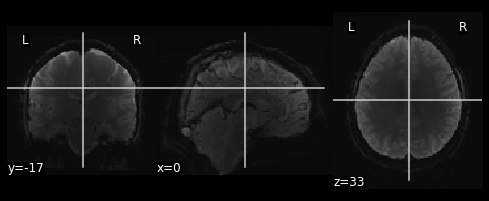

In [3]:
nilearn.plotting.plot_anat(template)

Register reference images to template:

## ToM hypothesis spaces
We are using ToM hypothesis spaces derived from a large sample of adults run on the same ToM localizer task as our participants ([source](http://saxelab.mit.edu/use-our-theory-mind-group-maps); [Dufour et al., 2013](http://saxelab.mit.edu/sites/default/files/images/Dufour_2013.pdf)).

Load original ROI files:

In [4]:
roi_dir = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library'
in_dir = opj(roi_dir, 'spm_space')
out_dir = opj(roi_dir, 'fmriprep_space')

roi_files = gsearch(in_dir, '*xyz.nii.gz')
roi_files.sort()
print('Original ROI files:')
print(*roi_files, sep='\n')

print('Saving new ROIs to: %s' % out_dir)
if not os.path.isdir(out_dir):
    print('Made new directory')
    os.makedirs(out_dir)

Original ROI files:
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/DMPFC_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/LTPJ_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/MMPFC_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/PC_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/RSTS_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/RTPJ_xyz.nii.gz
/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/spm_space/VMPFC_xyz.nii.gz
Saving new ROIs to: /ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space


In [ ]:
report_dir = 'outputs/roi_registration'
if not os.path.isdir(report_dir):
    os.makedirs(report_dir)

for roi in roi_files:
    
    #Get ROI name
    roi_label = re.search('[A-Z]+(?=_xyz.nii.gz)', roi).group(0)
    roi_report = opj(report_dir, '%s_report.txt' % roi_label)
    roi_plot_file = roi_report.replace('report.txt', 'img.png')
    roi_out = opj(out_dir, '%s.nii.gz') % roi_label
    
    # Resample ROI
    resampled_roi = nilearn.image.resample_to_img(roi, template, interpolation = 'nearest')

    # Generate report
    roi_img = nilearn.image.load_img(roi)

    original_shape = roi_img.shape
    original_affine = roi_img.affine

    resampled_shape = resampled_roi.shape
    resampled_affine = resampled_roi.affine

    template_img = template
    template_shape = template_img.shape
    template_affine = template_img.affine

    with open(roi_report, 'w+') as outfile:
        print("========= %s =========" % roi_label, file=outfile)
        print("""Shape comparison:
        - Original image shape : {0}
        - Resampled image shape: {1}
        - Template image shape       : {2}
        """.format(original_shape, resampled_shape, template_shape), file=outfile)

        print("""Affine comparison:
        - Original image affine :\n {0}
        - Resampled image affine:\n {1}
        - Template image affine       :\n {2}
        """.format(original_affine, resampled_affine, template_affine), file=outfile)

    # Plot ROI
    roi_plot = nilearn.plotting.plot_roi(resampled_roi, title='%s search space' % roi_label)
    roi_plot.savefig(roi_plot_file)

    # Save ROI to ROI library
    nb.save(resampled_roi, roi_out)

/n/home_fasse/nvelezalicea/.conda/envs/py3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


## ACC

Based on prior literature (Neubert et al, 2015; Apps et al., 2016; Lockwood et al., 2018), we define ACCg anatomically as area 24 in the [Neubert cingulate/orbitofrontal atlas](http://www.rbmars.dds.nl/CBPatlases.htm).

Load atlas description:

In [ ]:
atlas_dir = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/NeubertCingulateOrbitoFrontalParcellation'
data_dir = '/users/nvelezalicea/teaching/BIDS_data'

# Read atlas labels, ROI coordinates from XML file
atlas_data_file = gsearch(atlas_dir, '*.xml')
atlas_data = ET.parse(atlas_data_file[0]).findall('data')[0]
atlas_list = []

for region in atlas_data:
    region_info = region.attrib.copy()
    region_info['label'] = region.text
    atlas_list.append(region_info)
    
atlas_df = pd.DataFrame(atlas_list)
atlas_df['index'] = atlas_df['index'].astype(int)+1
atlas_df['label'] = atlas_df['label'].str.lower()

# Just pick out ACC
acc_regions = atlas_df[atlas_df.label.str.contains('area 24')]
acc_regions

Load atlas:

In [ ]:
atlas_file = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/NeubertCingulateOrbitoFrontalParcellation/CingulateOrbitoFrontal_thr50_summaryimage_1mm.nii.gz'
atlas_img_original = nilearn.image.load_img(atlas_file)
nilearn.plotting.plot_roi(atlas_img_original)

In [ ]:
atlas_mtx = atlas_img_original.get_fdata()
resampled_list = []

for _, row in acc_regions.iterrows():    
    # Load ROI from atlas
    acc_mtx = (atlas_mtx == row['index'])*1
    acc_img = nilearn.image.new_img_like(atlas_img_original, acc_mtx)
    
    #Get ROI name
    roi_side = re.search('left|right', row.label).group(0)
    roi_label = roi_side[0]+'ACC'
    roi_report = opj(report_dir, '%s_report.txt' % roi_label)
    roi_plot_file = roi_report.replace('report.txt', 'img.png')
    roi_out = opj(out_dir, '%s.nii') % roi_label
        
    # Resample ROI
    resampled_acc = nilearn.image.resample_to_img(acc_img, template, interpolation = 'nearest')

    # Generate report
    original_shape = acc_img.shape
    original_affine = acc_img.affine

    resampled_shape = resampled_acc.shape
    resampled_affine = resampled_acc.affine

    template_img = template
    template_shape = template_img.shape
    template_affine = template_img.affine
    
    with open(roi_report, 'w+') as outfile:
        print("========= %s =========" % roi_label, file=outfile)
        print("""Shape comparison:
        - Original image shape : {0}
        - Resampled image shape: {1}
        - Template image shape       : {2}
        """.format(original_shape, resampled_shape, template_shape), file=outfile)

        print("""Affine comparison:
        - Original image affine :\n {0}
        - Resampled image affine:\n {1}
        - Template image affine       :\n {2}
        """.format(original_affine, resampled_affine, template_affine), file=outfile)

    # Plot ROI
    roi_plot = nilearn.plotting.plot_roi(resampled_acc, title='%s search space' % roi_label)
    roi_plot.savefig(roi_plot_file)

    # Save ROI to ROI library
    nb.save(resampled_acc, roi_out)
    
    # Add to list of resampled ACC rois
    resampled_list.append(resampled_acc)

Make bilateral ACC ROI:

In [ ]:
bilateral_acc = nilearn.image.math_img("img1 + img2", img1=resampled_list[0], img2=resampled_list[1])
roi_plot = nilearn.plotting.plot_roi(bilateral_acc, title='Bilateral ACC')

In [ ]:
new_acc_img = nilearn.image.new_img_like(template, bilateral_acc.get_fdata(), copy_header=False)

roi_out = opj(out_dir, 'bilateral_ACCg.nii')
nb.save(new_acc_img, roi_out)

Check: Do any of the ToM search spaces overlap with ACC ROI?

In [ ]:
tom_files = os.listdir('/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space')
tom_files = [f for f in tom_files if 'ACC' not in f]

for f in tom_files:
    tom_roi = nilearn.image.load_img(opj(out_dir, f))

    intersect = nilearn.masking.intersect_masks([bilateral_acc, tom_roi])
    intersect_extent = np.sum(intersect.get_fdata())

    roi_name = str_extract('^[A-Z]+', f)
    print(f'{roi_name}: {intersect_extent}')